## In this notebook, I will be working with a dataset from the UC Irvine Machine Learning Repository (citation below). This is a dataset of census data in the US from 1994. Throughout this notebook, I will perform Exploritory Data Analysis (EDA) as well as creating a Machine Learning Model to help me predict if someone makes more or less than $50,000 based on a number of features that we feed the data. I wll also be using an Ensemble Method to try and increase accuracy and ensure my model is not overfitted. 

###### Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

#### The first step is to load our dataset and take a look at what we are working with. 

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [4]:
import pandas as pd

# creating dataframe
df = pd.concat([X, y], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# learning about the type of data I will be working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## EDA

#### After loading our dataset and getting a feel for how the data is structred, we can now begin our EDA. We will take a look at and resolve issues such as: missing values, duplicate rows, and unbalanced data. 

In [6]:
# checking for null values
df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

#### In this dataset, the missing values that we have are in columns that have a variety of different categorical responses. We also have a maximum of 966 missing values in one column, which accounts for 2% of our total data. Because this number is less than the common threshold of 5% of our data, we can safetly drop these rows instead of imputing them. 

In [7]:
# dropping null rows
df.dropna(inplace = True)
# checking my work
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [8]:
# checking for duplicate rows
df.duplicated().sum()

np.int64(29)

In [9]:
# double checking the duplicate rows before removing them
all_duplicates = df[df.duplicated(keep=False)]
print(all_duplicates)

       age         workclass  fnlwgt     education  education-num  \
2303    90           Private   52386  Some-college             10   
3917    19           Private  251579  Some-college             10   
4325    25           Private  308144     Bachelors             13   
4767    21           Private  250051  Some-college             10   
4881    25           Private  308144     Bachelors             13   
4940    38           Private  207202       HS-grad              9   
5104    90           Private   52386  Some-college             10   
5579    27           Private  255582       HS-grad              9   
5805    20           Private  107658  Some-college             10   
5842    25           Private  195994       1st-4th              2   
6990    19           Private  138153  Some-college             10   
7053    49  Self-emp-not-inc   43479  Some-college             10   
7920    49           Private   31267       7th-8th              4   
8080    21           Private  2433

In [10]:
# dropping duplicate rows
df.drop_duplicates(inplace = True)

# checking my work
df.duplicated().sum()

np.int64(0)

#### After looking at my dataset again, and understanding what each column of data contains, I found that column "fnlwgt" has no recorded meaning on the webiste where the data was pulled from. I think we can drop this column, but I will check to make sure it is not strongly correlated with anything before doing so. In order to do that, I will need to one hot encode my categorical variables to numerical. 

In [11]:
# clean data
df["income"] = df["income"].str.strip()        # remove whitespace
df["income"] = df["income"].str.replace(".", "", regex=False)  # remove period
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})

# One-hot encode the entire DataFrame
df_encoded = pd.get_dummies(df)

print("\nEncoded DataFrame:")
print(df_encoded)


Encoded DataFrame:
       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0       39   77516             13          2174             0              40   
1       50   83311             13             0             0              13   
2       38  215646              9             0             0              40   
3       53  234721              7             0             0              40   
4       28  338409             13             0             0              40   
...    ...     ...            ...           ...           ...             ...   
48836   33  245211             13             0             0              40   
48837   39  215419             13             0             0              36   
48839   38  374983             13             0             0              50   
48840   44   83891             13          5455             0              40   
48841   35  182148             13             0             0              60   

       

In [12]:
# creating correlation matrix
correlation_matrix = df_encoded.corr()

print(correlation_matrix)

                                     age    fnlwgt  education-num  \
age                             1.000000 -0.075777       0.033141   
fnlwgt                         -0.075777  1.000000      -0.040974   
education-num                   0.033141 -0.040974       1.000000   
capital-gain                    0.077999 -0.003896       0.125609   
capital-loss                    0.057736 -0.004958       0.081796   
...                                  ...       ...            ...   
native-country_Thailand        -0.001812 -0.001548       0.007257   
native-country_Trinadad&Tobago  0.001080  0.004194      -0.010472   
native-country_United-States    0.012176 -0.071172       0.112906   
native-country_Vietnam         -0.012642 -0.007606      -0.007874   
native-country_Yugoslavia       0.002974  0.004748      -0.005996   

                                capital-gain  capital-loss  hours-per-week  \
age                                 0.077999      0.057736        0.079061   
fnlwgt         

#### fnlwgt has almost no correlation with any other feature, and has no documentation of what it represents. Because of this, I feel confident dropping the column. 

In [13]:
# dropping fnlwgt
df_encoded.drop(columns = 'fnlwgt', inplace = True)

# checking my work
df_encoded.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47592 entries, 0 to 48841
Columns: 108 entries, age to native-country_Yugoslavia
dtypes: bool(102), int64(6)
memory usage: 7.2 MB


#### Now that I have cleaned my data up a bit, let's take a look at the distribution of our target variable (income), to see if we have a balanced or unbalanced dataset. For clarification, our code has made it to where if the person made less than $50,000, they are marked labeled as "0". If they make more, they are instead labeled as "1".

In [15]:
# finding the count of each label
df_encoded['income'].value_counts()

income
0    36053
1    11539
Name: count, dtype: int64

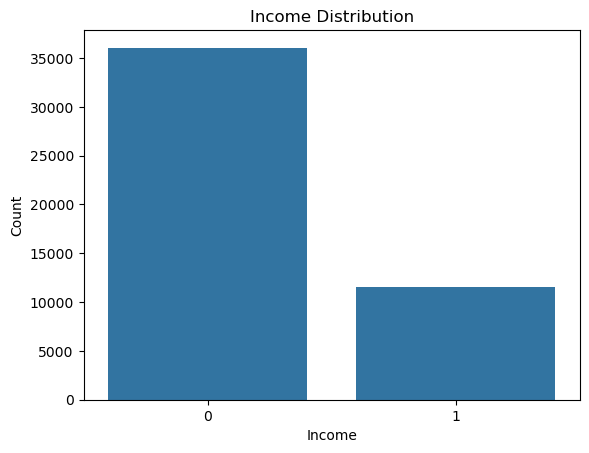

In [16]:
# vizualizing the distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='income', data = df_encoded)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

#### Our visualization shows us that this income data is a little unbalanced in favor of those who make less than $50,0000/yr. This will be something that we will have to keep our eye on to make sure that it does not significantly affect our model. 

## Logistic Regression Model Creation

#### The first model I will build will be a logistic regression model to predict if a person makes more or less than $50,000/yr. I will created my model, train it on the data, then test it with data it has not seen before. After doing that, we will evaluate how well our model performed.

In [17]:
# importing libraries needed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# defining features and target variable
X = df_encoded.drop('income', axis = 1)
y = df_encoded['income']

# splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [18]:
# creating model and scaling the data
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

# fitting the model to the data and making predicitons
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# checking the predictions
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[8374,  639],
       [1148, 1737]])

Text(0.5, 427.9555555555555, 'Predicted label')

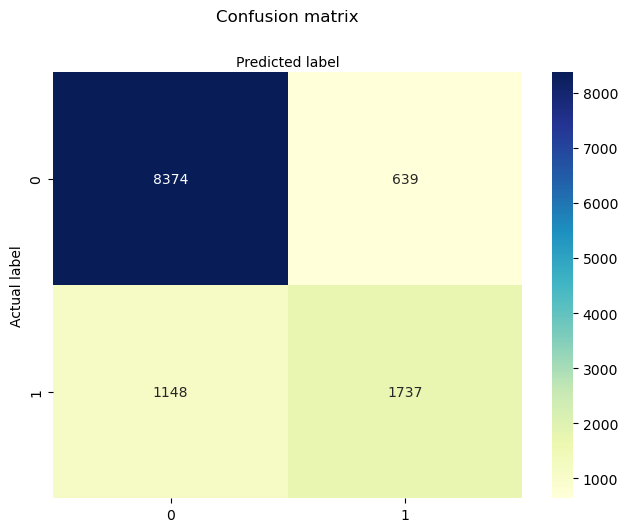

In [20]:
# visualizing the predictions made by the model
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Evaluation

In [21]:
# import libraries
from sklearn.metrics import (
accuracy_score,
classification_report,
precision_score,
recall_score,
f1_score,
roc_auc_score,
roc_curve
)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Precision, Recall, F1
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.850
Precision: 0.7310606060606061
Recall: 0.6020797227036395
F1 Score: 0.6603307356015966

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9013
           1       0.73      0.60      0.66      2885

    accuracy                           0.85     11898
   macro avg       0.81      0.77      0.78     11898
weighted avg       0.84      0.85      0.84     11898



#### After running the data through the logistic regression model, I found that it performed with an overall accuracy of 85%. With how unbalanced our dataset was at the beginning, I am overall pleased with these results.

#### The next thing I would like to do is run a Gradient Boosting Model through my data to try and see if I can improve accuracy by combining predictions of potentially weaker learners to create a more accurate, stonger model. I will create the model, check the accuracy, and check for overfitting in my model. 

In [22]:
# importing library
from sklearn.ensemble import GradientBoostingClassifier

# creating model 
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# fitting and running model 
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

# checking accuracy
print("GB Accuracy:", accuracy_score(y_test, gb_preds))
print("GB AUC:", roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))

GB Accuracy: 0.8721633888048411
GB AUC: 0.9265149646159091


#### Overall, my Gradient Boosting Model performed with an 87% accuracy, which is 2% better than the Logistic Regression model. This is because the model combined multiple predictors to create one powerful model. Essentially, we expanded the data "horizon" to increase our accuracy. One potential issue with this could be overfitting the model to the data, since it sees the data so many times. So for my next step, I will be checking for overfitting in my model. 

Cross-validation scores for each fold: [0.86616241 0.86868369 0.87434335 0.86709393 0.8724522 ]
Mean accuracy across all folds: 0.87
Standard deviation of accuracies: 0.00


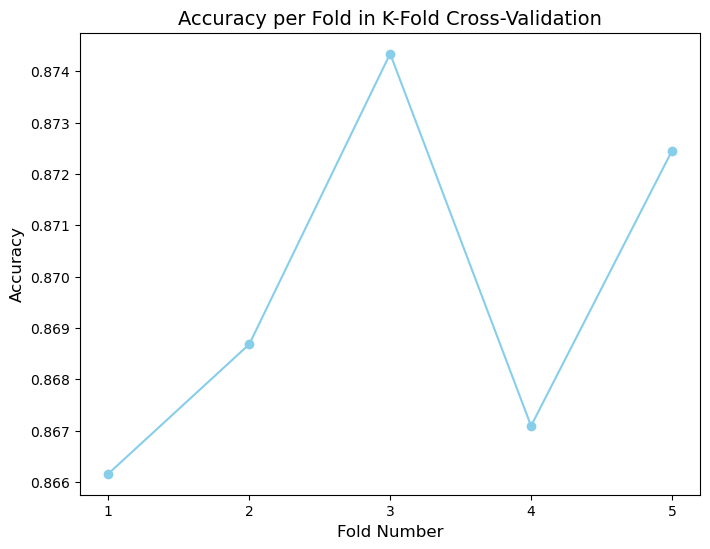

In [23]:
# import library
from sklearn.model_selection import cross_val_score

# Perform K-fold cross-validation with 5 folds
cv_scores = cross_val_score(gb, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores for each fold: {cv_scores}")
print(f"Mean accuracy across all folds: {np.mean(cv_scores):.2f}")
print(f"Standard deviation of accuracies: {np.std(cv_scores):.2f}")

# Plot fold number vs accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Accuracy per Fold in K-Fold Cross-Validation', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(1, len(cv_scores) + 1))  # Ensure x-ticks correspond to each fold number

# Show the plot
plt.show()

#### I am very happy with the result of our accuracy per fold test with this model. We can see in the visualization that each Fold has it's own unique accuracy score (which confirms that the model did not overfit on the data), and all of our accuracy scores are fairly close together (within 1% of each other). My model performs with a high level of accuracy and reasonably consistant output. 

#### The final thing I would like to do is to visualize which feature had the most impact on the outcome of the model. This dataset has a lot of columns, and a lot of variables that could potentially effect the results of the model. Thinking of this, I want to see which variable has the most impact, to answer the question - "What column effects the persons ability to earn over $50,0000 the most?".

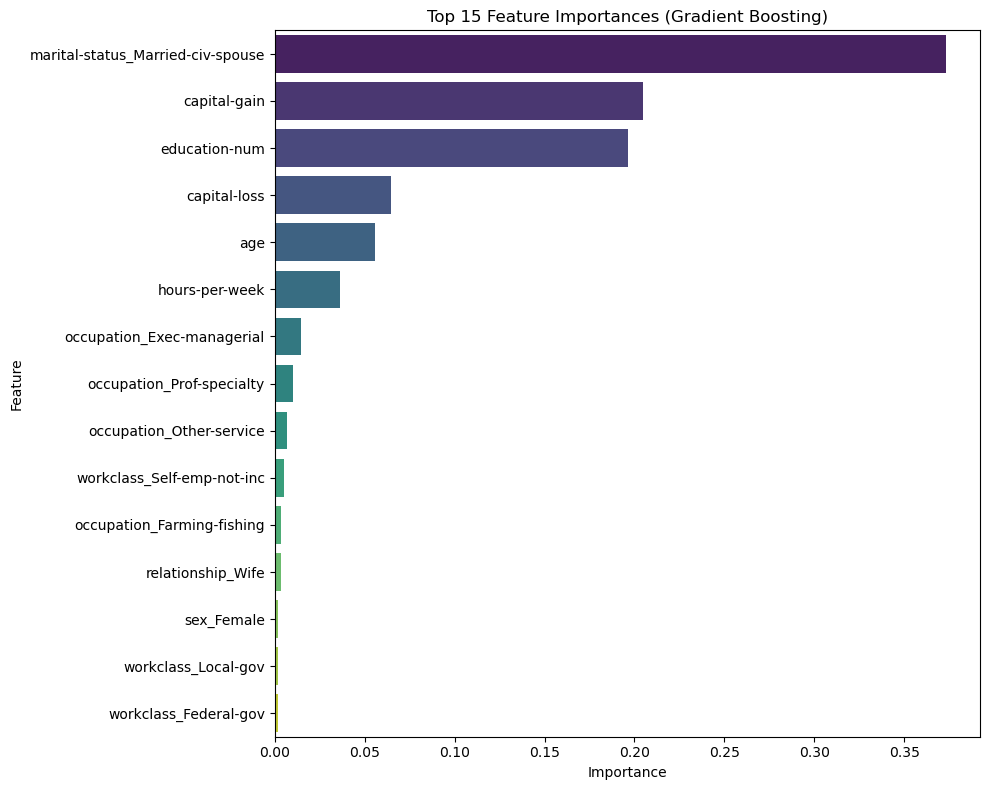

In [24]:
# Extract importance
importances = gb.feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10,8))
sns.barplot(
    data=importance_df.head(15),
    x="Importance",
    y="Feature",
    palette="viridis"
)

plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.tight_layout()
plt.show()

#### To me, this is a very interesting result of the feature importance visualization. The top three features that impact our model are:
### 1. Marital status. If you are married, you are much more likely to make over $50,000. This could be attributed to the idea that when you are married, you may have more financial responsibilities, so you need to make more money. 
### 2. Capital gain. This one makes sense to me, as this column is very skewed and unbalanced. If you make more money, you are more likely to have higher capital gains than someone who makes significantly less. 
### 3. Education. This one also makes sense to me since most of the time, if you get an education you are more likely to make it into higher paying jobs. 

#### What is interesting to me about this chart is that things that I thought would be more impactful (Sex, Hours per Week, and individual occupations) do not have as much of an impact. This shows the importance of digging in the data to find out what the facts are about the data we have. 

## Conclusion

#### Throughout this notebook, I explored a unique and extremely useful dataset of census data from 1994. I was able to identify problems with the data, such as missing values, duplicate rows, and improper formatting in our target variable values. I corrected these and built two powerful Machine Learning Models to help me predict if a person makes over $50,000/yr by only using the data that we have available in the census data. My models performed with moderately high accuracy and did not overfit on the data. 

#### This notebook shows us that if we want to increase the income for ourselves and those around us, we can focus on the features that have the most impact and use those to increase personal income. 